In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizerFast
from transformers import TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

In [27]:
tf.config.run_functions_eagerly(True)

**loading the data**

In [2]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')


In [3]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


**cleaning the data**

In [4]:
df.isna().sum()

Sentence     0
Sentiment    0
dtype: int64

In [5]:
df.duplicated().sum()

6

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.Sentiment.value_counts()

Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64

<Axes: xlabel='Sentiment', ylabel='count'>

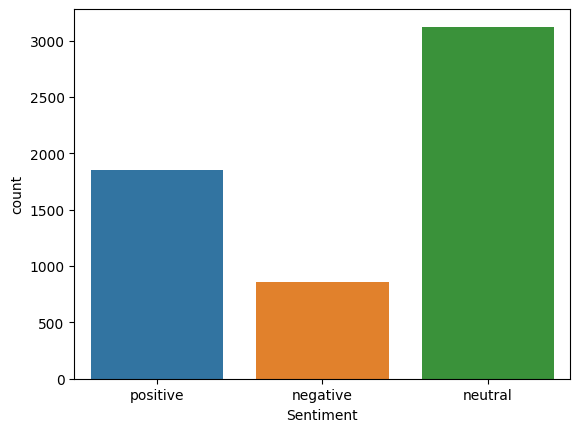

In [8]:
import seaborn as sns
sns.countplot(x=df.Sentiment)

In [9]:
df.Sentence = df.Sentence.str.lower()
df.head()

,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,positive
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",negative
2,"for the last quarter of 2010 , componenta 's n...",positive
3,according to the finnish-russian chamber of co...,neutral
4,the swedish buyout firm has sold its remaining...,neutral


In [10]:
df['Sentiment'] = df['Sentiment'].map({
    'positive':2,
    'neutral':1,
    'negative':0
})
df.head()

,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,2
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",0
2,"for the last quarter of 2010 , componenta 's n...",2
3,according to the finnish-russian chamber of co...,1
4,the swedish buyout firm has sold its remaining...,1


**creating dependent and independent vars, then splitting into train and test**

In [11]:
X = list(df['Sentence'])
y = list(df['Sentiment'])

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [16]:
y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train.shape)
print(y_test.shape)

(4377,)
(1459,)


In [22]:
y_train.size

4377

**loading the tokenizer for the dedicated model**

In [17]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

**tokenizing the train and test inputs**

In [18]:
X_train = tokenizer(X_train,truncation=True,padding=True)
X_test = tokenizer(X_test,truncation=True,padding=True)

**creating dataset as a tf**

In [19]:
train_df = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
test_df = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))

**shuffling and batching the data**

In [23]:
train_df = train_df.shuffle(len(X_train)).batch(8)
test_df = test_df.batch(8)

In [24]:
for batch in train_df.take(1):
    print(f"Train batch input_ids shape: {batch[0]['input_ids'].shape}")
    print(f"Train batch labels shape: {batch[1].shape}")

Train batch input_ids shape: (8, 150)
Train batch labels shape: (8,)


In [25]:
for batch in test_df.take(1):
    print(f"Validation batch input_ids shape: {batch[0]['input_ids'].shape}")
    print(f"Validation batch labels shape: {batch[1].shape}")

Validation batch input_ids shape: (8, 120)
Validation batch labels shape: (8,)


**loading the pretrained model then compiling  it**

In [20]:
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

**model fitting**

In [28]:
history = model.fit(train_df,
                    validation_data=test_df,
                    epochs=3)

Epoch 1/3
548/548 [==============================] - 552s 1s/step - loss: 0.6010 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.4629 - val_sparse_categorical_accuracy: 0.8040
Epoch 2/3
548/548 [==============================] - 549s 1s/step - loss: 0.3468 - sparse_categorical_accuracy: 0.8357 - val_loss: 0.4958 - val_sparse_categorical_accuracy: 0.8101
Epoch 3/3
548/548 [==============================] - 547s 999ms/step - loss: 0.2666 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.5888 - val_sparse_categorical_accuracy: 0.8019


In [30]:
model.evaluate(test_df)

183/183 [==============================] - 22s 122ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.8019


[0.5887531638145447, 0.8019191026687622]

**making predictions on test set**

In [32]:
pred = model.predict(test_df)['logits']

183/183 [==============================] - 18s 99ms/step


In [33]:
probability = tf.nn.softmax(pred)

In [34]:
class_preds = np.argmax(probability,axis=1)
class_preds

array([2, 1, 1, ..., 1, 0, 1])